# Evaluation for trained model to decode 32 bits polar code 

In [1]:
import sys, pathlib

p = pathlib.Path.cwd()
while p != p.parent:
    if (p / "models").exists():
        project_root = p
        break
    p = p.parent

sys.path.insert(0, str(project_root))

In [2]:
import json

In [3]:
import re, matplotlib.pyplot as plt, os

In [4]:
import torch
from dataset import PolarDecDataset 
from models.wrappers.mamba_32bits import MambaPolarDecoder

from torch.utils.data import DataLoader

/home/anjal/Desktop/Code/mamba-seq-pred/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
N = 32

In [7]:
model = MambaPolarDecoder(
    d_model=64,
    num_layer_encoder=1,
    num_layers_bimamba_block=32,
    seq_len=N,
    d_state=32,
    d_conv=4,
    expand=2
).to(device)
model

MambaPolarDecoder(
  (discrete_embedding): Embedding(2, 64)
  (linear_embedding1): Linear(in_features=1, out_features=64, bias=True)
  (linear_embedding2): Linear(in_features=1, out_features=64, bias=True)
  (linear_input_layer): Linear(in_features=192, out_features=64, bias=True)
  (encoder_layers): ModuleList(
    (0): BiMambaEncoder(
      (layers): ModuleList(
        (0-31): 32 x BiMambaBlock(
          (pre_ln_f): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
          (mamba_f): Mamba(
            (in_proj): Linear(in_features=64, out_features=256, bias=False)
            (conv1d): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
            (act): SiLU()
            (x_proj): Linear(in_features=128, out_features=68, bias=False)
            (dt_proj): Linear(in_features=4, out_features=128, bias=True)
            (out_proj): Linear(in_features=128, out_features=64, bias=False)
          )
          (post_ln_f): LayerNorm((64,), eps=1e-05, elementw

In [8]:
ckpt_path = "../checkpoints/config_2/model_epoch_1.pt" 

In [9]:
ckpt = torch.load(ckpt_path, map_location=device)
ckpt

{'comments': 'Set the loss function to evaluate loss for both frozen and non frozen bits. set expand=3',
 'model_config': {'d_model': 64,
  'num_layer_encoder': 1,
  'num_layers_bimamba_block': 32,
  'seq_len': 32,
  'd_state': 32,
  'd_conv': 4,
  'expand': 2},
 'epoch': 2,
 'train_loss': 0.15826351968944072,
 'val_loss': tensor(0.1571, device='cuda:0'),
 'state_dict': OrderedDict([('alpha', tensor(1., device='cuda:0')),
              ('beta', tensor(1., device='cuda:0')),
              ('gamma', tensor(1., device='cuda:0')),
              ('discrete_embedding.weight',
               tensor([[ 1.1123e-06, -2.0150e-03, -6.5119e-07, -2.3464e-06,  1.1511e-07,
                         6.4793e-07,  1.9278e-03,  7.5716e-04, -3.3575e-07, -9.5809e-08,
                        -1.0641e-05,  2.1285e-07, -3.2762e-10,  6.7614e-04,  1.0492e-04,
                         6.9252e-02, -9.8329e-04,  1.8033e-07,  1.1761e-05,  2.0968e-04,
                         2.7869e-03,  2.9942e-05,  8.6027e-02, -3.1

### Loss Trend

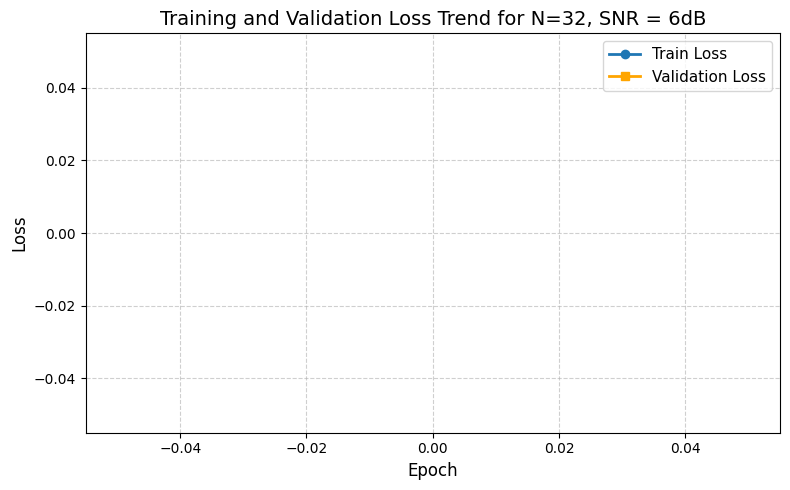

In [9]:
ckpt_dir = pathlib.Path("../checkpoints")  
pattern = re.compile(r"model_epoch_(\d+)\.pt$")

records = []

# load (epoch, train_loss, valid_loss)
for ckpt_file in ckpt_dir.glob("model_epoch_*.pt"):
    m = pattern.search(ckpt_file.name)
    if not m:
        continue
    epoch = int(m.group(1))
    ckpt = torch.load(ckpt_file, map_location="cpu")
    train_loss = ckpt.get("train_loss")
    valid_loss = ckpt.get("valid_loss")
    if train_loss is not None and valid_loss is not None:
        records.append((epoch, train_loss, valid_loss))


records.sort(key=lambda x: x[0])

epochs = [r[0] for r in records]
train_losses = [r[1] for r in records]
valid_losses = [r[2] for r in records]


plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss', linewidth=2)
plt.plot(epochs, valid_losses, marker='s', label='Validation Loss', linewidth=2, color='orange')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Trend for N=32, SNR = 6dB", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()



### Metrics

In [10]:


# load model
state_dict = ckpt.get("model_state_dict", ckpt.get("state_dict", ckpt))
model.load_state_dict(state_dict, strict=False)

<All keys matched successfully>

In [11]:
test_set = PolarDecDataset(snr_db=10, num_samples=32000, fixed_msg_bit_size=24)
test_dataloader = DataLoader(test_set, batch_size = 32)

In [32]:
channel_tensor, frozen_tensor, snr_tensor, target_tensor= next(iter(test_dataloader))
ip1 = channel_tensor.float().to(device)
ip2 = frozen_tensor.int().to(device)
ip3 = snr_tensor.float().to(device)

#print(ip2[0])

predicted = model(ip1, ip2, ip3) #works

 #loss = calculate_loss_for_reliable_bits_only(ip2, target_tensor.to(device), predicted.to(device), loss_fn) #works


#print(f"Channel Observation Vector: {ip1.shape}\nFrozen Tensor: {ip2.shape}\n")
#print(f"Predicted Channel Input Vector(logits): {predicted.shape}\n\n")

#print(f"Predicted (sigmoid): {torch.sigmoid(predicted)}\n\n")
pred = (torch.sigmoid(predicted) > 0.5).long()[0]

print(f"Actual bits:     {''.join(str(int(i)) for i in target_tensor[0])}\n")
print(f"Predicted bits:  {''.join(map(str, pred.cpu().tolist()))}\n")

#print(f"Loss: {loss}")

Actual bits:     00110111000101101100000000100000

Predicted bits:  00010001000101100000000000100000



In [33]:


def calc_save_ber(model, device , msg_bit_sizes:list, snr_db=10, num_samples=32000, json_file_name=None):
    """
    Calculate BER over a test dataset and saves the detailed data of bit errors for frozen and non frozen bits

    Args:
        test_loader: PyTorch DataLoader providing (channel, frozen, snr, target)
        model: trained model
        device: torch device (cpu or cuda)
    
    Returns:
        float: average BER over the test set
    """

    eval_results = {}

    for each_msg_bit_size in msg_bit_sizes:

        print(f"Evaluating bit error rates for message bit size {each_msg_bit_size}...\n\n")
      
       
        total_msg_bit_errors = 0
        total_frozen_bit_errors = 0
        total_frozen_bits = 0
        total_msg_bits = num_samples*each_msg_bit_size

        test_set = PolarDecDataset(snr_db=snr_db, num_samples=num_samples, fixed_msg_bit_size=each_msg_bit_size)
        test_loader = DataLoader(dataset=test_set, batch_size = 32)

        model.eval()
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                channel_tensor, frozen_tensor, snr_tensor, target_tensor = data
                
                
                ip1 = channel_tensor.float().to(device)
                ip2 = frozen_tensor.int().to(device)
                ip3 = snr_tensor.float().to(device)
                op = target_tensor.int().to(device)

            #  print(ip3.shape)

                
                predicted_vector = model(ip1, ip2, ip3)

                
                if predicted_vector.dtype != torch.bool and predicted_vector.dtype != torch.int:
                    predicted_vector = (predicted_vector > 0.5).int()

                
                mask_frozen = (ip2 != 0)
                mask_msg = (ip2 != 1)

                reliable_target = op[mask_msg]
                reliable_predicted = predicted_vector[mask_msg]

                frozen_targets = op[mask_frozen]
                frozen_predicted = predicted_vector[mask_frozen]

                
                msg_bit_errors = (reliable_target != reliable_predicted).sum().item()
                total_msg_bit_errors += msg_bit_errors
                
                frozen_bit_errors = (frozen_targets != frozen_predicted).sum().item()
                total_frozen_bit_errors += frozen_bit_errors
                total_frozen_bits += len(frozen_targets)

        
        total_bits = total_msg_bits + total_frozen_bits
        net_error_bits = total_frozen_bit_errors + total_msg_bit_errors

        avg_net_ber = net_error_bits/ total_bits 
        print(f"average_net_bit_error_rate : {avg_net_ber}\n")

        avg_msg_bits_ber = total_msg_bit_errors / total_msg_bits
        print(f"average_msg_bit_error_rate : {avg_msg_bits_ber}\n")

        avg_frozen_bits_ber = total_frozen_bit_errors/total_frozen_bits
        print(f"average_frozen_bit_error_rate : {avg_frozen_bits_ber}\n")
        
        eval_results[each_msg_bit_size] = {
            "average_net_bit_error_rate" : avg_net_ber,
            "average_msg_bit_bit_error_rate": avg_msg_bits_ber,
            "average_frozen_bits_bit_error_rate": avg_frozen_bits_ber,
            "batch_size": test_dataloader.batch_size,
            "num_samples": num_samples,
            "total_bits": total_bits,
            "total_error_bits": net_error_bits,
            "total_msg_bits": total_msg_bits,
            "total_frozen_bits": total_frozen_bits,
            "snr": snr_db
        }
    

    with open(f"{json_file_name}.json", "w") as f:
        json.dump(eval_results, f, indent=4)

    print(f"Results saved to {json_file_name}.json file of current directory!")
    

    return eval_results


In [35]:
calc_save_ber(model, device, msg_bit_sizes=[8, 16, 24], snr_db=10, json_file_name="evaluation_model_config_2")


Evaluating bit error rates for message bit size 8...


average_net_bit_error_rate : 0.034193359375

average_msg_bit_error_rate : 0.1367734375

average_frozen_bit_error_rate : 0.0

Evaluating bit error rates for message bit size 16...


average_net_bit_error_rate : 0.0941748046875

average_msg_bit_error_rate : 0.188349609375

average_frozen_bit_error_rate : 0.0

Evaluating bit error rates for message bit size 24...


average_net_bit_error_rate : 0.20365625

average_msg_bit_error_rate : 0.2715416666666667

average_frozen_bit_error_rate : 0.0

Results saved to evaluation_model_config_2.json file of current directory!


{8: {'average_net_bit_error_rate': 0.034193359375,
  'average_msg_bit_bit_error_rate': 0.1367734375,
  'average_frozen_bits_bit_error_rate': 0.0,
  'batch_size': 32,
  'num_samples': 32000,
  'total_bits': 1024000,
  'total_error_bits': 35014,
  'total_msg_bits': 256000,
  'total_frozen_bits': 768000,
  'snr': 10},
 16: {'average_net_bit_error_rate': 0.0941748046875,
  'average_msg_bit_bit_error_rate': 0.188349609375,
  'average_frozen_bits_bit_error_rate': 0.0,
  'batch_size': 32,
  'num_samples': 32000,
  'total_bits': 1024000,
  'total_error_bits': 96435,
  'total_msg_bits': 512000,
  'total_frozen_bits': 512000,
  'snr': 10},
 24: {'average_net_bit_error_rate': 0.20365625,
  'average_msg_bit_bit_error_rate': 0.2715416666666667,
  'average_frozen_bits_bit_error_rate': 0.0,
  'batch_size': 32,
  'num_samples': 32000,
  'total_bits': 1024000,
  'total_error_bits': 208544,
  'total_msg_bits': 768000,
  'total_frozen_bits': 256000,
  'snr': 10}}

## Evaluating model's performance on frozen bits vs non frozen bits

In [31]:
msg_bit_sizes = [8, 16, 24]

In [32]:
test_set = PolarDecDataset(snr_db=10, num_samples=320, fixed_msg_bit_size=msg_bit_sizes[0])
test_dataloader = DataLoader(test_set, batch_size = 32)

In [63]:
model.eval()
with torch.no_grad():

    for i, data in enumerate(test_dataloader):
        channel_tensor, frozen_tensor, snr_tensor, target_tensor = data
        
        ip1 = channel_tensor.float().to(device)
        ip2 = frozen_tensor.int().to(device)
        ip3 = snr_tensor.float().to(device)
        op = target_tensor.int().to(device)

        predicted_vector = model(ip1, ip2, ip3)

        if predicted_vector.dtype != torch.bool and predicted_vector.dtype != torch.int:
                predicted_vector = (predicted_vector > 0.5).int()

         
        mask = (ip2 != 0)
        frozen_target = op[mask]
        frozen_predicted = predicted_vector[mask]
        print(frozen_predicted)
        break
        


tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,